In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import os
import gstools as gs
import segyio

from scipy.ndimage import map_coordinates, gaussian_filter
from scipy.interpolate import interp1d

In [78]:
#Loading seismic using Segyio lib

# string containing the path location of the seismic data at disk
segy_file_path = '..\Seismic\TIME_R0321_COMPLEX_ALBACORA_PSDM_4ms.segy'

#loading stack using Segyio lib
stack = segyio.open(segy_file_path,iline=segyio.TraceField.INLINE_3D, 
                xline=segyio.tracefield.TraceField.CROSSLINE_3D) 
#Allocating IL, XL, Time axis in variables
il, xl, t = stack.ilines, stack.xlines, stack.samples
#Measuring Sample rate from data samples
dt = t[1] - t[0]
#Creating seismic cube format using segyio cube method
data_cube = segyio.cube(stack)
#Qc of the axis shapes
nil, nxl, nt = data_cube.shape

# Inlines information
il_start, il_end = il[0], il[-1]
    
# Crosslines information
xl_start, xl_end = xl[0], xl[-1]

In [92]:
print('Seismic amplitude data information \n --------------------------------------------------')
print('Shape of data [n_il, n_xl, n_samples]: ', nil, nxl, nt)
print('Inline start:', il_start, '    ', 'Inline end:', il_end)
print('Crossline start:', xl_start, '    ', 'Crossline end:', xl_end)
print('Sample rate [ms]:', dt)
print('Two-way-time array:', t)

Seismic amplitude data information 
 --------------------------------------------------
Shape of data [n_il, n_xl, n_samples]:  1798 1995 1695
Inline start: 1366      Inline end: 3163
Crossline start: 1713      Crossline end: 3707
Sample rate [ms]: 3.99
Two-way-time array: [0.00000e+00 3.99000e+00 7.98000e+00 ... 6.75108e+03 6.75507e+03
 6.75906e+03]


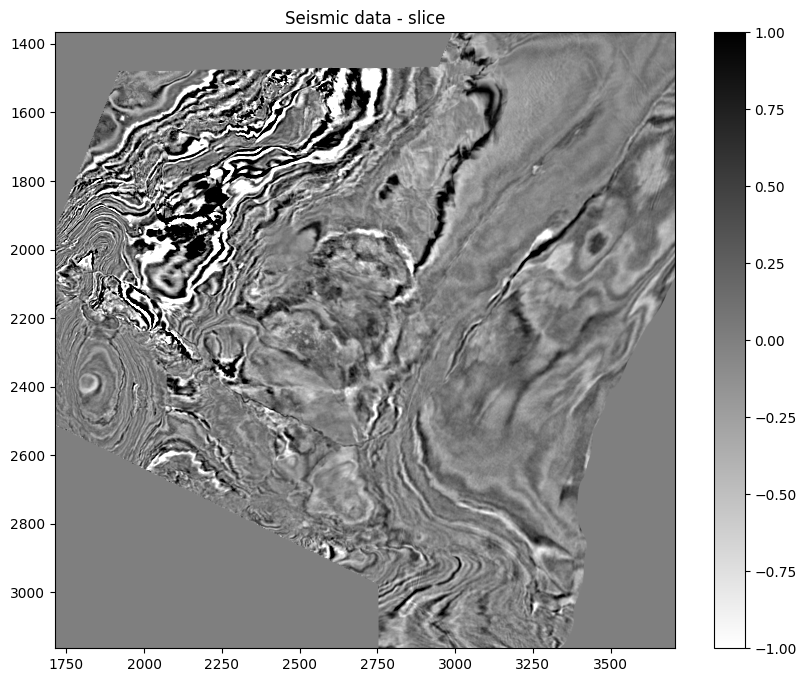

In [90]:
plt.figure(figsize=(10, 8))
plt.imshow(data_cube[..., 860], cmap='gray_r', vmin=-1, vmax=1,
           extent=(xl_start, xl_end, il_end, il_start))
plt.title('Seismic data - slice')
plt.colorbar()
plt.axis('tight');

(3400.0, 2300.0)

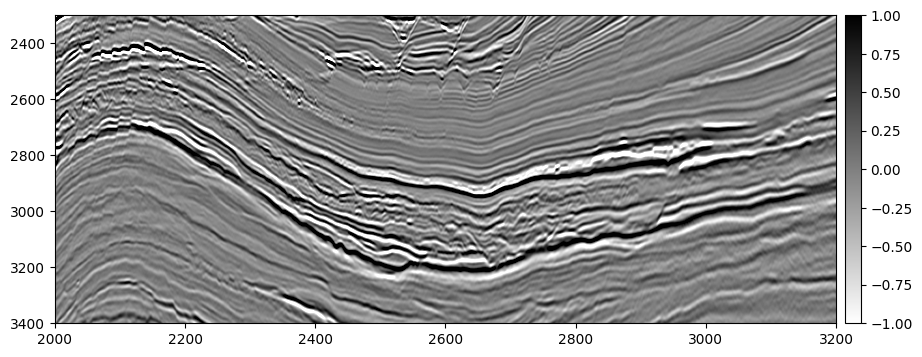

In [106]:
#plotting data
fig, ax = plt.subplots(figsize=(12, 4))
c=ax.imshow(data_cube[2594-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
plt.colorbar(c, ax=ax, pad=0.01)
ax.set_xlim(2000, 3200)
ax.set_ylim(3400, 2300)

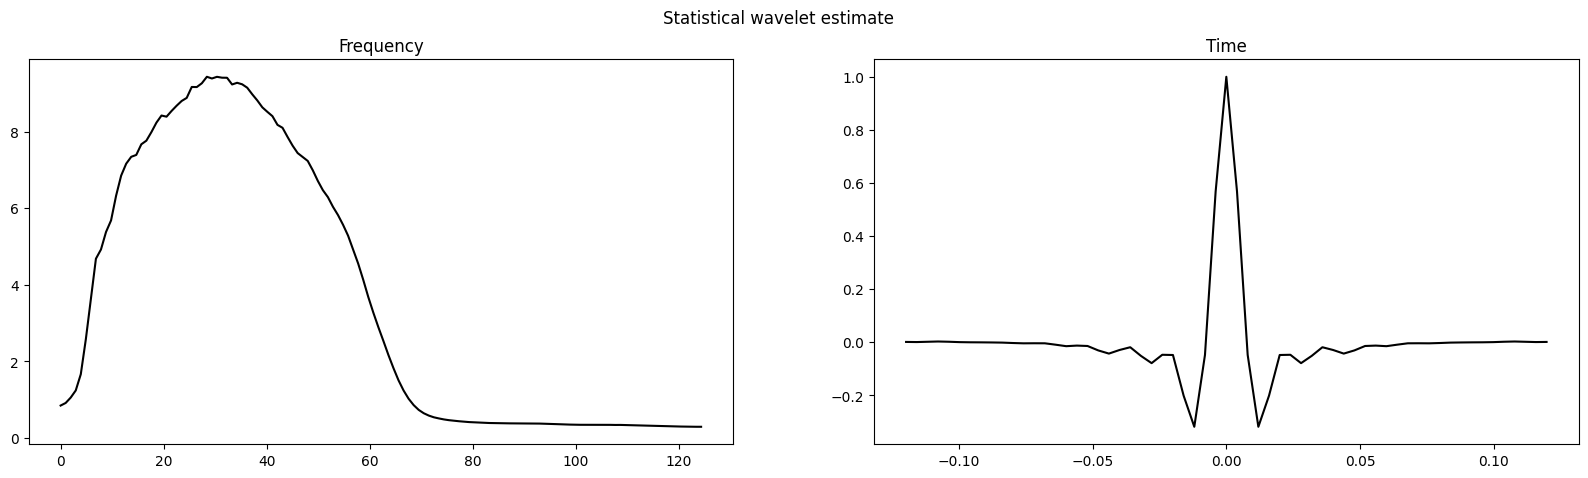

In [114]:
nt_wav = 31 # lenght of wavelet in samples
nfft = 2**8 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(data_cube[..., 500:860], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

In [92]:
#Reading Top horizon
topo = pd.read_csv("..\Horizons\\MAIO_23_updated\\ABL_140_TOPO_updated.dat",
                 sep='\s+', usecols=(0, 1, 4), names=['X', 'Y', 'Z'])
#Reading Base horizon
base = pd.read_csv("..\Horizons\\IN_XLINES\\BASE_AB_140_SEISWORKS.dat",
                 sep='\s+', usecols=(0, 1, 4), names=['X', 'Y', 'Z'])
#Reading Base horizon
mazul = pd.read_csv("..\Horizons\\IN_XLINES\\MAZUL_SEISWORKS.dat",
                 sep='\s+', usecols=(0, 1, 4), names=['X', 'Y', 'Z'])

In [93]:
#Print top hotrizon first 5 rows
topo.head()

X     Y         Z
0  1366  1713  3670.506
1  1366  1714  3670.193
2  1366  1715  3669.947
3  1366  1716  3669.700
4  1366  1717  3669.454

In [94]:
#Printing base horizon first 5 rows
base.head()

X     Y         Z
0  1366  1713  3685.101
1  1366  1714  3684.694
2  1366  1715  3683.881
3  1366  1716  3683.068
4  1366  1717  3682.255

In [95]:
#Printing mazul horizon first 5 rows
mazul.head()

X     Y         Z
0  1366  1713  4009.585
1  1366  1714  4009.259
2  1366  1715  4008.934
3  1366  1716  4008.608
4  1366  1717  4008.283

(3400.0, 2400.0)

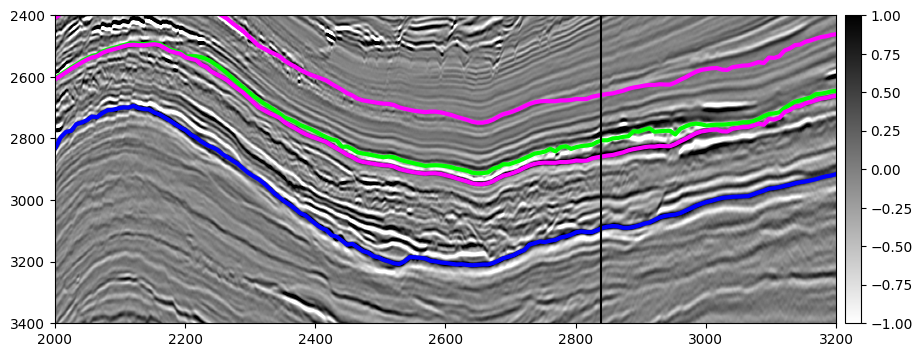

In [101]:
#Seismic and horizons overlaid
fig, ax = plt.subplots(figsize=(12, 4))

c=ax.imshow(data_cube[2594-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])

plt.colorbar(c, ax=ax, pad=0.01)

ax.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z,
         color='lime', lw=3.0)
ax.plot(base.loc[base.X == 2594].Y, base.loc[base.X == 2594].Z,
         color='magenta', lw=3.0)
ax.plot(mazul.loc[mazul.X == 2594].Y, mazul.loc[mazul.X == 2594].Z,
         color='blue', lw=3.0)
ax.plot(base.loc[base.X == 2594].Y, base.loc[base.X == 2594].Z - 200,
         color='magenta', lw=3.0)

ax.axvline(2839, color='k')
ax.set_xlim(2000, 3200)
ax.set_ylim(3400, 2400)

In [102]:
#Accessing wells names 
path = "..\Wells_LowFreq/Wells/"
for idx, file in enumerate(os.listdir(path)):
    
    print(file)
    names.append(files)

3-RJS-360A-RJS_BEST_SET.las
4-RJS-477A-RJ_BEST-SET.las
9-ABL-2-RJS_BEST_SET.las
9-ABL-3B-RJS_BEST_SET.las
9-ABL-5-RJS_BEST_SET.las
9-ABL-6A-RJS_BEST_SET.las
9-ABL-7-RJS_BEST_SET.las
9-ABL-83D-RJS_BEST_SET.las
9-ABL-9D-RJS_BEST_SET.las


In [103]:
#List of wells positions
positions = [
    [2510, 2985], # 360A
    [2255, 3228], # 477A
    [2650, 2929], # 9ABL2
    [2301, 2994], # 9ABL3B
    [2594, 2839], # 9ABL5
    [2694, 2768], # 9ABL6A
    [2450, 2926], # 9ABL7
    [2615, 2665], # 9ABL83D
    [2253, 2754], # 9ABL9D
]
#List of wells names
wells_names = [
'360A',
'477A',
'9ABL2',
'9ABL3B',
'9ABL5',
'9ABL6A',
'9ABL7',
'9ABL83D',
'9ABL9D',
]

In [141]:
#Create Top surface
topo_surface = np.full((nil, nxl), np.nan, dtype=np.float32)

ils = np.arange(il_start, il_end+1, 1, dtype=int)
xls = np.arange(xl_start, xl_end+1, 1, dtype=int) 

for idx, inline in enumerate(ils):
    x = topo.loc[topo.X == inline].Y
    y = topo.loc[topo.X == inline].Z
    
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    
    topo_surface[idx, :] = interp(xls)
    
    print(f'Inline {inline}/{ils[-1]}\r', end="")

topo_surface = topo_surface.T

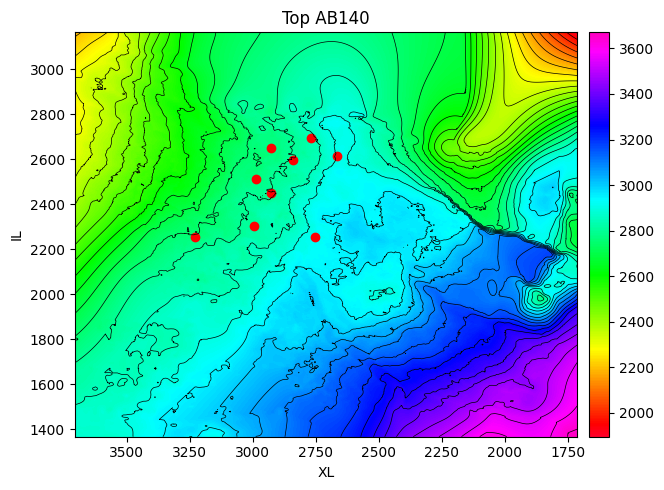

In [142]:
#Plotting wells and Top surface overlaid
plt.figure(figsize=(7, 5))
c=plt.imshow(topo_surface.T, aspect='auto', cmap='gist_rainbow',extent=[xl_start, xl_end, il_end, il_start])
plt.contour(topo_surface.T[::-1, :], colors='k', levels=40, linewidths=0.5, extent=[xl_start, xl_end, il_end, il_start])
plt.colorbar(c, pad=0.02)
plt.xlabel('XL')
plt.ylabel('IL')
plt.title('Top AB140')

for idx, pos in enumerate(positions):
    plt.scatter(pos[1], pos[0], color='r')
    
plt.tight_layout()

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [143]:
#Create Top surface
base_surface = np.full(((nil, nxl)), np.nan, dtype=np.float32)

ils = np.arange(il_start, il_end+1, 1, dtype=int)
xls = np.arange(xl_start, xl_end+1, 1, dtype=int) 

for idx, inline in enumerate(ils):
    x = base.loc[base.X == inline].Y
    y = base.loc[base.X == inline].Z
    
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    
    base_surface[idx, :] = interp(xls)
    
    print(f'Inline {inline}/{ils[-1]}\r', end="")
base_surface = base_surface.T

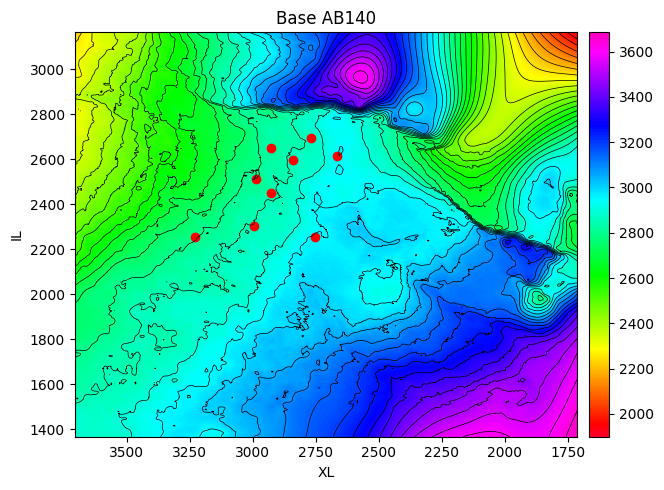

In [144]:
#Plotting wells and Base surface overlaid
plt.figure(figsize=(7, 5))
c=plt.imshow(base_surface.T, aspect='auto', cmap='gist_rainbow', extent=[xl_start, xl_end, il_end, il_start])
plt.contour(base_surface.T[::-1, :], colors='k', levels=40, linewidths=0.5, extent=[xl_start, xl_end, il_end, il_start])
plt.colorbar(c, pad=0.02)
plt.xlabel('XL')
plt.ylabel('IL')
plt.title('Base AB140')

for idx, pos in enumerate(positions):
    plt.scatter(pos[1], pos[0], color='r')
    #plt.text(pos[1]-50, pos[0]-40, wells_names[idx], color='w', size=13)

plt.tight_layout()

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [145]:
#Create Mazul surface
mazul_surface = np.full(((nil, nxl)), np.nan, dtype=np.float32)
ils = np.arange(il_start, il_end+1, 1, dtype=int)
xls = np.arange(xl_start, xl_end+1, 1, dtype=int) 

for idx, inline in enumerate(ils):
    x = mazul.loc[mazul.X == inline].Y
    y = mazul.loc[mazul.X == inline].Z
    
    interp = interp1d(x, y, bounds_error=False, fill_value='extrapolate')
    
    mazul_surface[idx, :] = interp(xls)
    
    print(f'Inline {inline}/{ils[-1]}\r', end="")
mazul_surface = mazul_surface.T

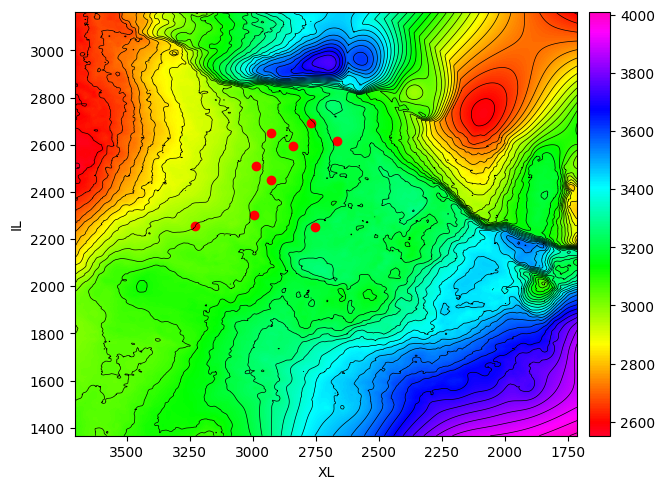

In [146]:
plt.figure(figsize=(7, 5))
c=plt.imshow(mazul_surface.T, aspect='auto', cmap='gist_rainbow', extent=[xl_start, xl_end, il_end, il_start])
plt.contour(mazul_surface.T[::-1, :], colors='k', levels=40, linewidths=0.5, extent=[xl_start, xl_end, il_end, il_start])
plt.colorbar(c, pad=0.02)
plt.xlabel('XL')
plt.ylabel('IL')

for idx, pos in enumerate(positions):
    plt.scatter(pos[1], pos[0], color='r')
    #plt.text(pos[1]-50, pos[0]-40, wells_names[idx], color='w', size=13)

plt.tight_layout()

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [147]:
#Needed to shift the Top surface up
topo_surface_shift = topo_surface - 180

In [148]:
# Building rgt

rgts = np.zeros((600, 1995, 1798))

for i in range(0, topo_surface.shape[1]):
    rgt = np.full((600, topo_surface.shape[0]), np.nan)
    
    domain = np.arange(topo_surface.shape[0])
    
    top = np.full_like(domain, 1700)
    bas = np.full_like(domain, 4100)
    
    ab140_t = (topo_surface[:, i] - 1700) // 4
    ab140_b = (base_surface[:, i] - 1700) // 4
    mazul_b = (mazul_surface[:, i] - 1700) // 4
    ab140_t_shift = (topo_surface_shift[:, i] - 1700) // 4
    top = ((top - 1700) // 4)
    bas = ((bas - 1700) // 4) - 1

    sl1 = np.zeros((600, len(domain)))
    sl2 = np.zeros((600, len(domain)))
    sl3 = np.zeros((600, len(domain)))
    sl4 = np.zeros((600, len(domain)))
    sl5 = np.zeros((600, len(domain)))

    for j in range(len(domain)):
        sl1[:, j] = np.linspace(mazul_b[j], bas[j], 600).astype(int)
        sl2[:, j] = np.linspace(ab140_b[j], mazul_b[j], 600).astype(int)
        sl3[:, j] = np.linspace(ab140_t[j], ab140_b[j], 600).astype(int)
        sl4[:, j] = np.linspace(ab140_t_shift[j], ab140_t[j], 600).astype(int)
        sl5[:, j] = np.linspace(top[j], ab140_t_shift[j], 600).astype(int)
    
    rgt[sl1.astype(int), np.repeat(np.expand_dims(domain, 1), 600, axis=1).T] = np.repeat(np.expand_dims(np.linspace(770, 1000, 600), 1), len(domain), axis=1)
    rgt[sl2.astype(int), np.repeat(np.expand_dims(domain, 1), 600, axis=1).T] = np.repeat(np.expand_dims(np.linspace(540, 770, 600), 1), len(domain), axis=1)
    rgt[sl3.astype(int), np.repeat(np.expand_dims(domain, 1), 600, axis=1).T] = np.repeat(np.expand_dims(np.linspace(460, 540, 600), 1), len(domain), axis=1)
    rgt[sl4.astype(int), np.repeat(np.expand_dims(domain, 1), 600, axis=1).T] = np.repeat(np.expand_dims(np.linspace(230, 460, 600), 1), len(domain), axis=1)
    rgt[sl5.astype(int), np.repeat(np.expand_dims(domain, 1), 600, axis=1).T] = np.repeat(np.expand_dims(np.linspace(0, 230, 600), 1), len(domain), axis=1)

    rgts[:, :, i] = rgt
    
    print(f"{i}\r", end="")

In [149]:
topo_shift = topo.copy()
topo_shift['Z'] = topo['Z'] - 180

(3400.0, 2400.0)

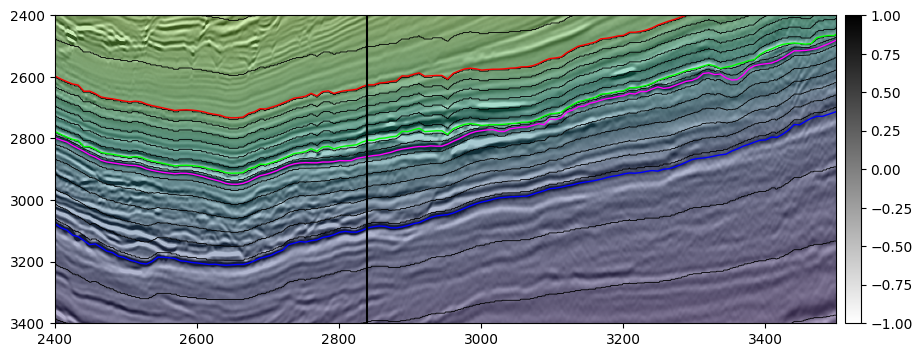

In [151]:
fig, ax = plt.subplots(figsize=(12, 4))

c=ax.imshow(data_cube[2594-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
ax.imshow(rgts[:, :, 2594-il_start], aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
          alpha=0.4, cmap='viridis_r')
ax.contour(rgts[::-1, :, 2594-il_start], colors='k', levels=30, linewidths=0.6,
           extent=[xl_start, xl_end, 4100, 1700])

plt.colorbar(c, ax=ax, pad=0.01)

ax.plot(topo_shift.loc[topo_shift.X == 2594].Y, topo_shift.loc[topo_shift.X == 2594].Z,
         color='red', lw=1.0)
ax.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z,
         color='lime', lw=1.0)
ax.plot(base.loc[base.X == 1594].Y, base.loc[base.X == 2594].Z,
         color='magenta', lw=1.0)
ax.plot(mazul.loc[mazul.X == 2594].Y, mazul.loc[mazul.X == 2594].Z,
         color='blue', lw=1.0)

ax.axvline(2839, color='k')
ax.set_xlim(2400, 3500)
ax.set_ylim(3400, 2400)

In [152]:
path = "..\Wells_LowFreq/Wells/"
path2 = "..\Wells_LowFreq/TDR/"
skips = [50, 62, 86, 85, 86, 86, 87, 80, 79]
df = pd.DataFrame()

for idx, file in enumerate(os.listdir(path)):
    
    print(file)
    
    if file=='4-RJS-477A-RJ_BEST-SET.las':
         well = pd.read_csv(path+file, sep='\s+', skiprows=62, usecols=(0, 1, 7), names=['MD', 'FACIES', 'IP'])
    else:
        well = pd.read_csv(path+file, sep='\s+', skiprows=skips[idx], names=['MD', 'FACIES', 'IP'])
    well.replace(-9999.0, np.nan, inplace=True)
    well['IP'] = well['IP'] * 1000
    well['WELL'] = file.split('_')[0]
    #print(well)
    
    tdr_name = ''
    for j, f in enumerate(file.split('-')[0:3]):
        tdr_name += f
        if j != 2:
            tdr_name += '-'
    
    if tdr_name != '4-RJS-477A':
        tdr = pd.read_csv(path2+'TDR_'+tdr_name+'.csv', sep=';', usecols=(1, 2))
        tdr['TWT'] = 2*tdr.OWT.to_numpy()
    else:
        print(path2+'TDR_'+tdr_name+'.txt')
        tdr = pd.read_csv(path2+'TDR_'+tdr_name+'.txt', sep='\s+', skiprows=14, usecols=(3, 4), names=['TWT', 'MD'])
        tdr['TWT'] = tdr['TWT'] * -1
    
    
    #print(well)
    
    interp_tdr = interp1d(tdr['MD'], tdr['TWT'], fill_value='extrapolate', bounds_error=False)
    t_well = interp_tdr(well.MD)
    
    new_samples = np.arange(1700, 4100, 4)
    interp2 = interp1d(t_well, well.IP, bounds_error=False, fill_value='extrapolate')
    ip_ups = interp2(new_samples)
    
    arr = np.array([new_samples, ip_ups])
    nwell = pd.DataFrame(arr.T, columns=['TWT', 'IP_UPS'])
    nwell['WELL'] = file.split('_')[0]
    nwell['IP_UPS'] = nwell['IP_UPS'].fillna(method='bfill').fillna(method='ffill')
    
    df = pd.concat([df, nwell], ignore_index=True)

3-RJS-360A-RJS_BEST_SET.las
4-RJS-477A-RJ_BEST-SET.las
..\Wells_LowFreq/TDR/TDR_4-RJS-477A.txt
9-ABL-2-RJS_BEST_SET.las
9-ABL-3B-RJS_BEST_SET.las
9-ABL-5-RJS_BEST_SET.las
9-ABL-6A-RJS_BEST_SET.las
9-ABL-7-RJS_BEST_SET.las
9-ABL-83D-RJS_BEST_SET.las
9-ABL-9D-RJS_BEST_SET.las


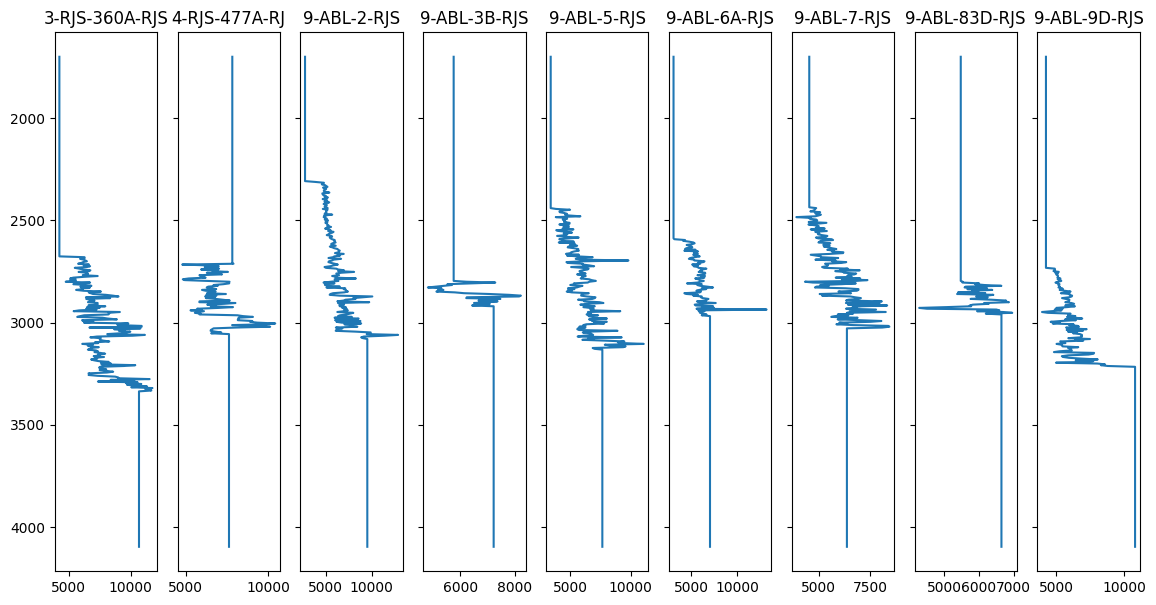

In [153]:
fig, ax = plt.subplots(1, 9, figsize=(14, 7), sharey=True)

for idx, well in enumerate(df.WELL.unique()):
    ax[idx].plot(df.loc[df.WELL==well, 'IP_UPS'],
             df.loc[df.WELL==well, 'TWT'])
    ax[idx].set_title(f'{well}')
ax[0].invert_yaxis()

In [154]:
ips = np.full_like(rgts, 0)
ips.shape

(600, 1995, 1798)

In [155]:
rel_positions = [
    [2985 - xl_start, 2510 - il_start], # 360A
    [3228 - xl_start, 2255 - il_start], # 477A
    [2929 - xl_start, 2650 - il_start], # 9ABL2
    [2994 - xl_start, 2301 - il_start], # 9ABL3B
    [2839 - xl_start, 2594 - il_start], # 9ABL5
    [2768 - xl_start, 2694 - il_start], # 9ABL6A
    [2926 - xl_start, 2450 - il_start], # 9ABL7
    [2665 - xl_start, 2615 - il_start], # 9ABL83D
    [2754 - xl_start, 2253 - il_start], # 9ABL9D
]

wells_names = [
'360A',
'477A',
'9ABL2',
'9ABL3B',
'9ABL5',
'9ABL6A',
'9ABL7',
'9ABL83D',
'9ABL9D',
]

In [156]:
for idx, p in enumerate(rel_positions):
    well = df.WELL.unique()[idx]
    print(well)
    ips[:, (p[0]-5):(p[0]+5), (p[1]-5):(p[1]+5)] = np.tile(df.loc[df.WELL==well, 'IP_UPS'].to_numpy(), (10, 10, 1)).T

3-RJS-360A-RJS
4-RJS-477A-RJ
9-ABL-2-RJS
9-ABL-3B-RJS
9-ABL-5-RJS
9-ABL-6A-RJS
9-ABL-7-RJS
9-ABL-83D-RJS
9-ABL-9D-RJS


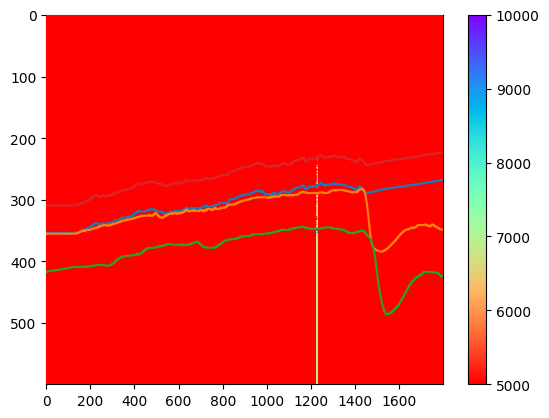

In [157]:
c=plt.imshow(ips[:, 2839-xl_start, :], cmap='rainbow_r', aspect='auto', zorder=10, vmin=5000, vmax=10000)
plt.plot((topo_surface[2839-xl_start, :]-1700)//4, zorder=20)
plt.plot((base_surface[2839-xl_start, :]-1700)//4, zorder=20)
plt.plot((mazul_surface[2839-xl_start, :]-1700)//4, zorder=20)
plt.plot((topo_surface_shift[2839-xl_start, :]-1700)//4, zorder=20)
plt.colorbar(c)
plt.grid(False)

In [158]:
# Taking the wells in all positions and transforming them
df['IP_FLAT'] = 0
for idx, p in enumerate(rel_positions):
    
    ip_trace = ips[:, p[0], p[1]]
    rgts_norm = (rgts - np.nanmin(rgts)) / (np.nanmax(rgts) - np.nanmin(rgts))
    rgt_trace = rgts_norm[:, p[0], p[1]] * rgts_norm.shape[0] - 1
    
    interpolator = interp1d(rgt_trace, ip_trace, fill_value='extrapolate', kind="linear")
    flat = np.arange(len(rgt_trace))
    
    transf = interpolator(flat)
    
    df.loc[df.WELL == df.WELL.unique()[idx], 'IP_FLAT'] = transf
    
    print(f"{idx}\r", end="")

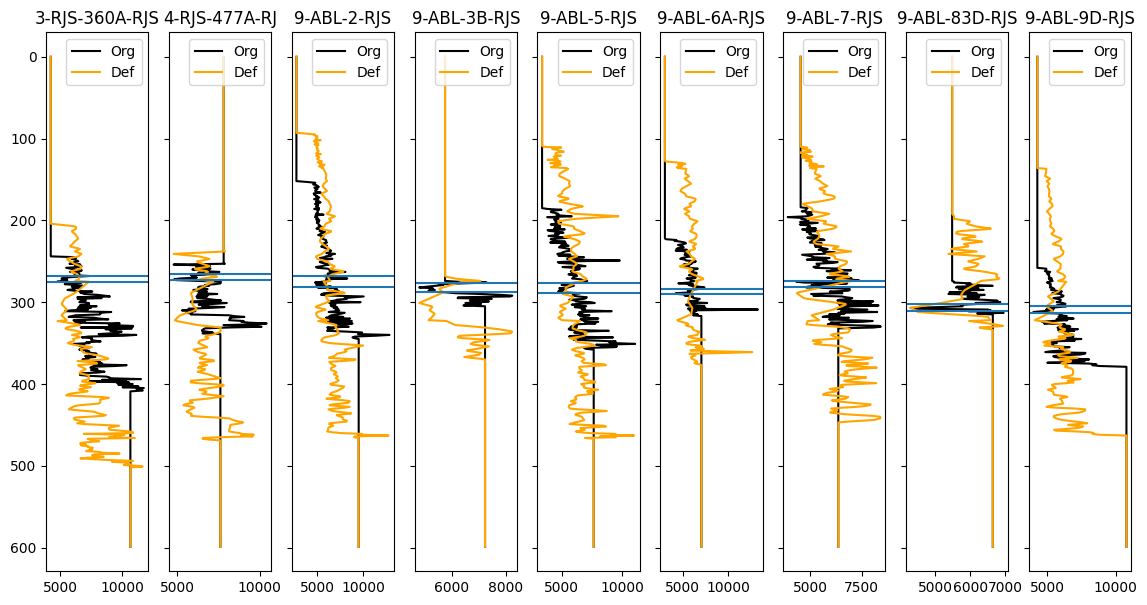

In [159]:
fig, ax = plt.subplots(1, 9, figsize=(14, 7), sharey=True)

for idx, well in enumerate(df.WELL.unique()):
    ax[idx].plot(df.loc[df.WELL==well, 'IP_UPS'], flat,
                 color='k', label='Org')
    ax[idx].plot(df.loc[df.WELL==well, 'IP_FLAT'], flat, 
                 color='orange', label='Def')
    ax[idx].legend(loc='upper right')
    ax[idx].set_title(f'{well}')
    ax[idx].axhline((topo_surface[rel_positions[idx][0], rel_positions[idx][1]] - 1700) // 4)
    ax[idx].axhline((base_surface[rel_positions[idx][0], rel_positions[idx][1]] - 1700) // 4)
ax[0].invert_yaxis()

In [160]:
gridx = np.arange(ips.shape[1], dtype=np.float32)
gridy = np.arange(ips.shape[2], dtype=np.float32)
gridz = np.arange(ips.shape[0], dtype=np.float32)

In [161]:
krig = np.zeros_like(ips)

for i in range(600):
    dvalues = []
    for well in df.WELL.unique():
        dvalues.append(df.loc[df.WELL==well].IP_FLAT.to_numpy()[i])
    dcoords = np.array(rel_positions)
    dvalues = np.expand_dims(np.array(dvalues, dtype=np.float32), axis=1)
    model = gs.Exponential(dim=2, len_scale=[250, 500], angles=-1)
    OK = gs.krige.Ordinary(model, [dcoords[:, 0], dcoords[:, 1]], dvalues, exact=True)
    kg = OK.structured([gridx, gridy])
    krig[i, :, :] = kg[0]
    print(f"{i}\r", end="")

In [162]:
low_freq = np.full_like(ips, np.nan)

for i in range(rgts_norm.shape[1]):
    
    ip_cut = krig[:, i, :]
    rgt_cut = rgts_norm[:, i, :]
    mask = ~np.isnan(rgt_cut)
    
    ip_cut = ip_cut[mask]
    rgt_cut = rgt_cut[mask]

    ip_cut = ip_cut.reshape((600, -1)).T
    rgt_cut = rgt_cut.reshape((600, -1)).T

    x, z = np.indices(rgt_cut.shape)
    rgt_cut *= rgt_cut.shape[1] - 1
    deformed = scipy.ndimage.gaussian_filter(map_coordinates(ip_cut, (x, rgt_cut)), sigma=(5, 6))
    
    whs = np.where(mask==True)
    
    
    if len(whs[1]) >= 1:
        low_freq[:, i, :][:, whs[1][0]:whs[1][-1]+1] = deformed.T
    
    print(f"{i}\r", end="")

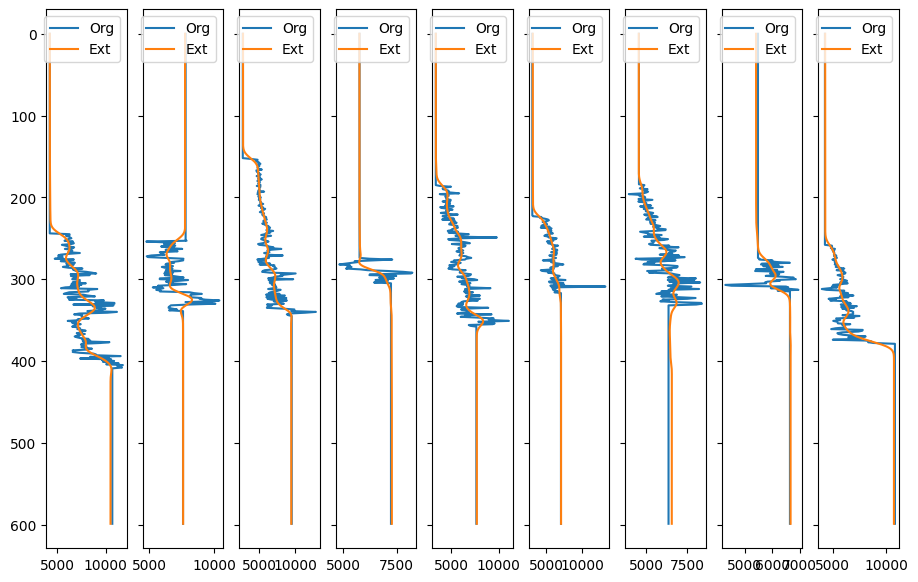

In [163]:
fig, ax = plt.subplots(1, 9, figsize=(11, 7), sharey=True)

for idx, pos in enumerate(rel_positions):
    ax[idx].plot(ips[:, pos[0], pos[1]], np.arange(600), label='Org')
    ax[idx].plot(low_freq[:, pos[0], pos[1]], np.arange(600), label='Ext')
    ax[idx].legend(loc='upper right')
ax[0].invert_yaxis()

In [164]:
mapa1 = np.full_like(topo_surface, np.nan)
mapa2 = np.full_like(base_surface, np.nan)

In [165]:
for i in range(topo_surface.shape[0]):
    for j in range(topo_surface.shape[1]):
        if ~np.isnan(topo_surface[i, j]):
            cut = (topo_surface[i, j] - 1700)//4
            mapa1[i, j] = low_freq[int(cut + 2) , i, j]
        
        if ~np.isnan(base_surface[i, j]):
            cut2 = (base_surface[i, j] - 1700)//4
            mapa2[i, j] = low_freq[int(cut2 - 3) , i, j]
            
    print(f"{i}/{topo_surface.shape[0]}\r", end="")
print()

1994/1995


In [166]:
ip_mask = np.full_like(low_freq[:, :, 2594-il_start].T, np.nan)
for i in range(len(ip_mask)):
    tss = topo_surface_shift[i, 2594-il_start]
    mas = mazul_surface[i, 2594-il_start]

    ip_mask[i, int((tss-1700)//4):int((mas-1700)//4)+1] = 1

    print(f"{i}\r", end="")

In [167]:
img = np.tile(df.loc[df.WELL=='9-ABL-5-RJS'].IP_UPS, (100, 1))

(3400.0, 2400.0)

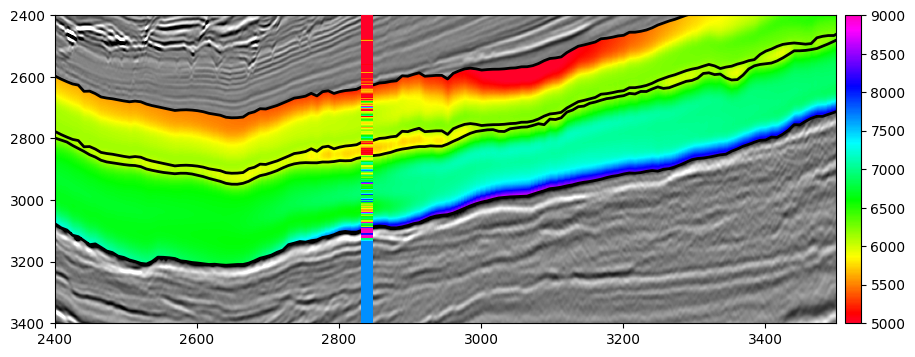

In [169]:
fig, ax = plt.subplots(figsize=(12, 4))

c=ax.imshow(data_cube[2594-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
#ax.imshow(rgts[:, :, 2594-il_start], aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
#          alpha=0.4, cmap='viridis_r')
#ax.contour(rgts[::-1, :, 2594-il_start], colors='k', levels=30, linewidths=0.6,
#           extent=[xl_start, xl_end, 4100, 1700])
c=ax.imshow(low_freq[:, :, 2594-il_start]*ip_mask.T, aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
          alpha=1.0, cmap='gist_rainbow', vmin=5000, vmax=9000)

ax.imshow(img.T, aspect='auto', cmap='gist_rainbow', vmin=5000, vmax=9000,
             extent=(2839-8, 2839+8, 4100, 1700), zorder=20)

plt.colorbar(c, ax=ax, pad=0.01)

ax.plot(topo_shift.loc[topo_shift.X == 2594].Y, topo_shift.loc[topo_shift.X == 2594].Z,
         color='k', lw=2.0)
ax.plot(topo.loc[topo.X == 2594].Y, topo.loc[topo.X == 2594].Z,
         color='k', lw=2.0)
ax.plot(base.loc[base.X == 2594].Y, base.loc[base.X == 2594].Z,
         color='k', lw=2.0)
ax.plot(mazul.loc[mazul.X == 2594].Y, mazul.loc[mazul.X == 2594].Z,
         color='k', lw=2.0)

ax.axvline(2839, color='k')
ax.set_xlim(2400, 3500)
ax.set_ylim(3400, 2400)

In [171]:
ip_mask = np.full_like(low_freq[:, :, 2694-il_start].T, np.nan)
for i in range(len(ip_mask)):
    tss = topo_surface_shift[i, 2694-il_start]
    mas = mazul_surface[i, 2694-il_start]

    ip_mask[i, int((tss-1700)//4):int((mas-1700)//4)+1] = 1

    print(f"{i}\r", end="")

(3400.0, 2400.0)

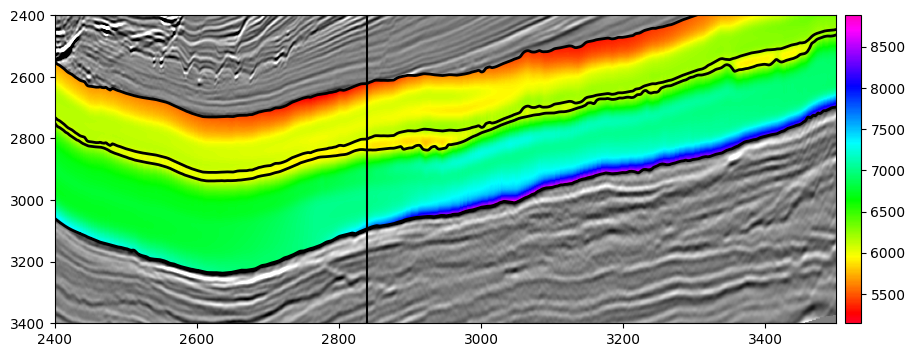

In [172]:
fig, ax = plt.subplots(figsize=(12, 4))

c=ax.imshow(data_cube[2694-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
#ax.imshow(rgts[:, :, 2694-il_start], aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
#          alpha=0.4, cmap='viridis_r')
#ax.contour(rgts[::-1, :, 2694-il_start], colors='k', levels=30, linewidths=0.6,
#           extent=[xl_start, xl_end, 4100, 1700])
c=ax.imshow(low_freq[:, :, 2694-il_start]*ip_mask.T, aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
          alpha=1.0, cmap='gist_rainbow')

plt.colorbar(c, ax=ax, pad=0.01)

ax.plot(topo_shift.loc[topo_shift.X == 2694].Y, topo_shift.loc[topo_shift.X == 2694].Z,
         color='k', lw=2.0)
ax.plot(topo.loc[topo.X == 2694].Y, topo.loc[topo.X == 2694].Z,
         color='k', lw=2.0)
ax.plot(base.loc[base.X == 2694].Y, base.loc[base.X == 2694].Z,
         color='k', lw=2.0)
ax.plot(mazul.loc[mazul.X == 2694].Y, mazul.loc[mazul.X == 2694].Z,
         color='k', lw=2.0)

ax.axvline(2839, color='k')
ax.set_xlim(2400, 3500)
ax.set_ylim(3400, 2400)

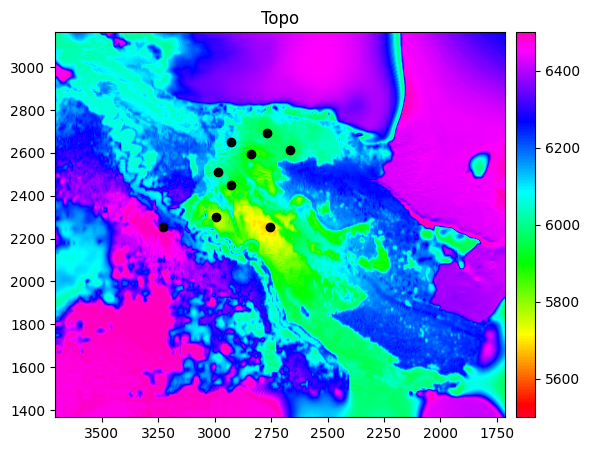

In [173]:
plt.figure(figsize=(7, 5))

c=plt.imshow(mapa1.T, cmap='gist_rainbow', aspect='auto', extent=[xl_start, xl_end, il_end, il_start],
             vmin=5500, vmax=6500)
plt.colorbar(c, pad=0.02)
#for idx, well in enumerate(df.WELL.unique()):
    #plt.scatter(positions[idx, 0], positions[idx, 1], 
                #c=df.loc[df.WELL==well].IP_UPS.to_numpy()[int((eoceno[int(positions[idx, 0]), positions[idx, 1]]-2700)//4)],
                #edgecolor='k', cmap='rainbow_r', vmin=5000, vmax=7000)
plt.title('Topo')

for idx, pos in enumerate(positions):
    plt.scatter(pos[1], pos[0], color='k')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

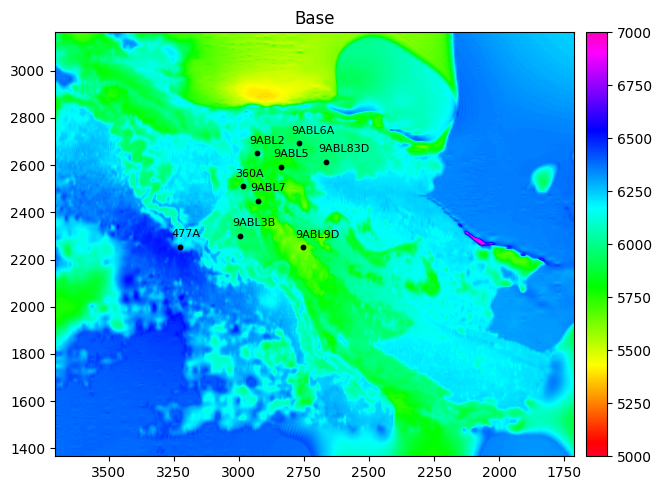

In [174]:
plt.figure(figsize=(7, 5))

c=plt.imshow(mapa2.T, cmap='gist_rainbow', aspect='auto', extent=[xl_start, xl_end, il_end, il_start],
             vmin=5000, vmax=7000)
plt.colorbar(c, pad=0.02)
#for idx, well in enumerate(df.WELL.unique()):
    #plt.scatter(positions[idx, 0], positions[idx, 1], 
                #c=df.loc[df.WELL==well].IP_UPS.to_numpy()[int((eoceno[int(positions[idx, 0]), positions[idx, 1]]-2700)//4)],
                #edgecolor='k', cmap='rainbow_r', vmin=5000, vmax=7000)
plt.title('Base')

for idx, pos in enumerate(positions):
    plt.scatter(pos[1], pos[0], color='k', s=10)
    plt.text(pos[1] + 30, pos[0] + 40, wells_names[idx], color='k', size=8)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.tight_layout()

In [175]:
low_freq_smooth = np.swapaxes(low_freq, 2, 0)

mask = np.full_like(low_freq_smooth, np.nan)

for i in range(mask.shape[0]):
    tss = (topo_surface_shift[:, i] - 1700) // 4
    mas = (mazul_surface[:, i] - 1700) // 4
    
    for j in range(len(tss)):
        mask[i, j, int(tss[j]):int(mas[j])] = 1
        
    print(f'Running inline {i} \r', end="")

In [183]:
del(data_cube)

In [205]:
ntraces = nil*nxl
zeros = np.zeros((ntraces,len(t)), dtype=np.float32)
lfmodel = np.reshape(low_freq_smooth, (low_freq_smooth.shape[0]*low_freq_smooth.shape[1], low_freq_smooth.shape[2]))
zeros[:, 425:1025] = lfmodel

In [206]:
with segyio.open(segy_file_path) as src:
    spec = segyio.spec()
    spec.sorting = src.sorting
    spec.format = src.format
    spec.samples = src.samples
    spec.ilines = src.ilines
    spec.xlines = src.xlines
    spec.header = src.header
    
    with segyio.create('../Low_Frequency_Model_Data/LF_Model_Angle45.sgy', spec) as dst:
        tr = 0
        for il in spec.ilines:
            for xl in spec.xlines:
                dst.header[tr] = {
                    segyio.su.iline : il,
                    segyio.su.xline : xl}
                
                dst.trace[tr] = zeros[tr]
                tr += 1
                
        dst.bin.update(
            tsort=segyio.TraceSortingFormat.INLINE_SORTING
        )

In [207]:
filename = "../Low_Frequency_Model_Data/LF_Model_Angle45.sgy"
with segyio.open(filename) as f:
    # Memory mapping the segy file
    f.mmap()
    
    # Verify the dimensions of 3D seismic data
    shape_lowf = (len(f.ilines), len(f.xlines), len(f.samples))
    
    # Inlines information
    il_start_lowf, il_end_lowf = f.ilines[0], f.ilines[-1]
    il_step_lowf = f.ilines[1] - f.ilines[0]
    
    # Crosslines information
    xl_start_lowf, xl_end_lowf = f.xlines[0], f.xlines[-1]
    xl_step_lowf = f.xlines[1] - f.xlines[0]
    
    # Get basic attributes
    n_traces_lowf = f.tracecount
    sample_rate_lowf = segyio.tools.dt(f) / 1000
    n_samples_lowf = f.samples.size
    twt_lowf = f.samples
    
    # Effectively stores all data into array 'traces'
    traces_lowf = f.trace.raw[:]

print('Seismic amplitude data information \n --------------------------------------------------')
print('Shape of data [n_il, n_xl, n_samples]: ', shape_lowf)
print('Inline start:', il_start_lowf, '    ', 'Inline end:', il_end_lowf, '    ', 'Inline step:', il_step_lowf)
print('Crossline start:', xl_start_lowf, '    ', 'Crossline end:', xl_end_lowf, '    ', 'Crossline step:', xl_step_lowf)
print('Number of traces [n_il*n_xl]:', n_traces_lowf)
print('Sample rate [ms]:', sample_rate_lowf)
print('Number of samples by trace:', n_samples_lowf)
print('Two-way-time array:', twt_lowf)

Seismic amplitude data information 
 --------------------------------------------------
Shape of data [n_il, n_xl, n_samples]:  (1798, 1995, 1695)
Inline start: 1366      Inline end: 3163      Inline step: 1
Crossline start: 1713      Crossline end: 3707      Crossline step: 1
Number of traces [n_il*n_xl]: 3587010
Sample rate [ms]: 3.99
Number of samples by trace: 1695
Two-way-time array: [0.00000e+00 3.99000e+00 7.98000e+00 ... 6.75108e+03 6.75507e+03
 6.75906e+03]


In [218]:
#del(zeros)

low_freq_smooth *= mask

(3400.0, 2400.0)

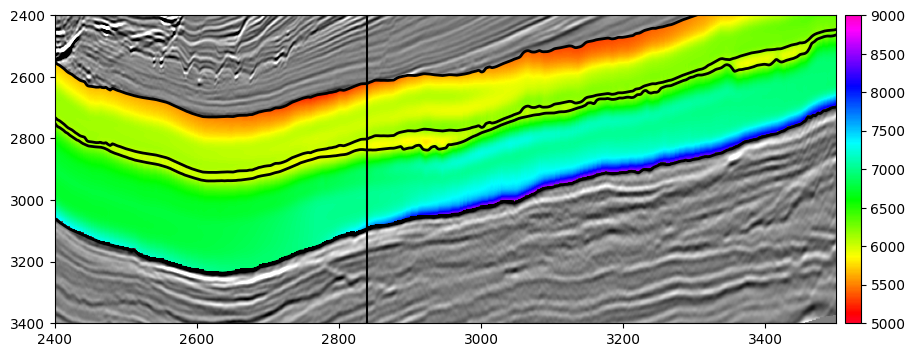

In [219]:
fig, ax = plt.subplots(figsize=(12, 4))

c=ax.imshow(data_cube[2694-il_start, :, :].T, aspect='auto', cmap='gray_r', vmin=-1, vmax=1,
            extent=[xl_start, xl_end, t[-1], t[0]])
c=ax.imshow(low_freq_smooth[2694-il_start, :, :].T, aspect='auto', extent=[xl_start, xl_end, 4100, 1700],
          alpha=1.0, cmap='gist_rainbow', vmin=5000, vmax=9000)

plt.colorbar(c, ax=ax, pad=0.01)

ax.plot(topo.loc[topo.X == 2694].Y, topo.loc[topo.X == 2694].Z,
         color='k', lw=2.0)
ax.plot(base.loc[base.X == 2694].Y, base.loc[base.X == 2694].Z,
         color='k', lw=2.0)
ax.plot(mazul.loc[mazul.X == 2694].Y, mazul.loc[mazul.X == 2694].Z,
         color='k', lw=2.0)
ax.plot(topo_shift.loc[topo_shift.X == 2694].Y, topo_shift.loc[topo_shift.X == 2694].Z,
         color='k', lw=2.0)

ax.axvline(2839, color='k')
ax.set_xlim(2400, 3500)
ax.set_ylim(3400, 2400)